# 7. Full inference

In this notebook we pull together all the elements of model and implement the algorithms for calculating uncertainties.

In [1]:
# allows for import from `src` directory
import sys 
sys.path.append('../')

from src import data
from src import utils

params = utils.read_json_params('../parameters.json')

# run the data preprocessing pipeline to create dataset
df, split_dfs, samples = data.pipeline(params['data']['n_input_steps'], params['models']['prediction']['n_output_steps'], '../data')

# we modify the get_datasets function to return external features in the y labels
datasets = data.get_datasets(samples, params['data']['n_input_steps'], pretraining=False)

dataloaders = data.get_dataloaders(datasets, train_batch_size=256)
# nb. batch_size refers to training batch_size which we have previously done hyperparameter
# on the pretraining and prediction networks for. it is irrelevant for this notebook because
# we will not be training anything

Data already downloaded

43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00

17341 samples of 48 input steps and 4 output steps in train
3622 samples of 48 input steps and 4 output steps in valid
4060 samples of 48 input steps and 4 output steps in test



In [2]:
import os
import torch
import numpy as np

import models.variational_dropout as vd
from models.predict import *

cpu = lambda x: x.cpu().detach().numpy()

def load_trained_model(params, device):
    # get paths to saved model artifact
    predict_loc = os.path.join(params['paths']['project_home'], params['paths']['artifacts'], 'predict.pt')
    
    # load, turn on evaluate mode    
    predict = torch.load(predict_loc, map_location=device).eval()
    
    return predict.to(device)

def dropout_on(m):
    if type(m) in [torch.nn.Dropout, vd.LSTM]:
        m.train()

def dropout_off(m):
    if type(m) in [torch.nn.Dropout, vd.LSTM]:
        m.eval()

## 7.1 Model uncertainty

`mc_dropout` implements §3.1.2 of the paper for calculating model uncertainty

In [3]:
def mc_dropout(params, predict, dataloader, B, use_tqdm=True):
    predict = predict.apply(dropout_on)

    pbar = range(B)
    if use_tqdm:
        from tqdm import tqdm
        pbar = tqdm(pbar)

    y_hats = []
    for b in pbar:
        for x,y in dataloader:
            x,y = x.to(device), y.to(device)
            break
        y_hat_b = predict((x, y[:,0,1:]))
        y_hats.append(cpu(y_hat_b))
    
    ymc_hats = np.mean(y_hats, axis=0)
    eta_1s   = np.mean((ymc_hats[:,0] - np.stack(y_hats)[:,:,0])**2, axis=0)
    return ymc_hats, eta_1s


## 7.2 Inherent noise

`inference` implements §3.1.3 of the paper for total prediciton uncertainty

In [4]:
device = utils.get_device()
predict = load_trained_model(params, device)

In [5]:
def inference(params, dataloaders, B, use_tqdm=True):
    device = utils.get_device()
    
    # mc dropout
    predict = load_trained_model(params, device)
    ymc_hats, eta_1s = mc_dropout(params, predict, dataloaders['test'], B)
    
    # inherent noise
    predict.apply(dropout_off)
    for x,y in dataloaders['valid']:
        x,y = x.to(device), y.to(device)
        break
    eta_2sq = np.mean(cpu(predict((x, y[:,0,1:])))[:,0])
    
    # total noise
    etas = np.sqrt(eta_1s + eta_2sq)
    
    return ymc_hats, etas


## 7.3 Run

In [6]:
# run the inference algorithm, this returns the mean predcitions for the test data
# and the associated uncertainty estimates
mu,eta = inference(params, dataloaders, 500)

# get the dataset scaling values to 'reinflate' the machine learning data back
# to the scale of the original data 
train_mu = datasets['test'].train_mu[-1]
train_sigma = datasets['test'].train_sigma[-1]

# scale the real output data Y and the predicted outputs Y_hat
Y = (dataloaders['test'].dataset.y[:,0,4]*train_sigma + train_mu)[:-48]
Y_hat = ((mu[:,0]+dataloaders['test'].dataset.X[:,0,4])*train_sigma + train_mu)[:-48]

# compute the upper/lower bounds using the uncertainty estimates
Y_hat_2upper = Y_hat + 2*eta[:-48] * Y_hat
Y_hat_2lower = Y_hat - 2*eta[:-48] * Y_hat
Y_hat_upper = Y_hat + eta[:-48] * Y_hat
Y_hat_lower = Y_hat - eta[:-48] * Y_hat


100%|██████████| 500/500 [04:35<00:00,  1.82it/s]


## 7.4 Plot

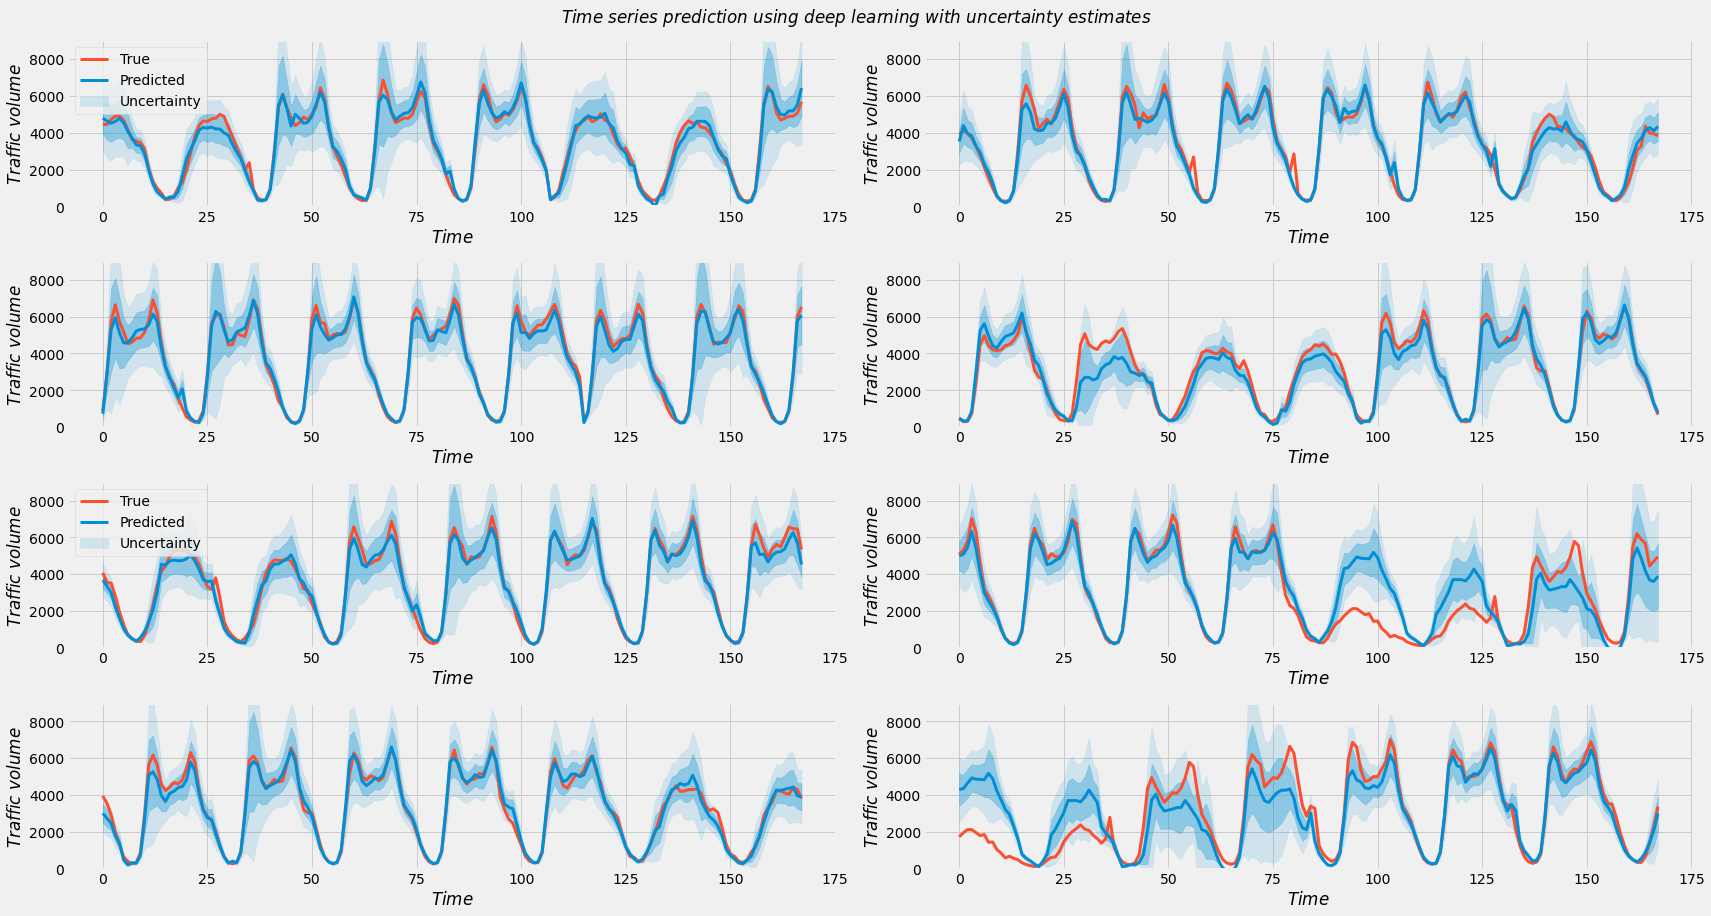

In [7]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

starts = np.random.randint(0,len(Y)-24*7,8)
fig,axs = plt.subplots(4,2,figsize=(24,13))
for i,(start,ax) in enumerate(zip(starts, np.hstack(axs))):
    end = start + 24*7
    ax.plot(Y[start:end], '-', lw=3, c='C1', label='True')
    ax.plot(Y_hat[start:end], lw=3, label='Predicted')
    ax.fill_between(np.arange(end-start),
                    Y_hat_upper[start:end], 
                    Y_hat_lower[start:end], 
                    alpha=0.33, color='C0')
    ax.fill_between(np.arange(end-start),
                    Y_hat_2upper[start:end], 
                    Y_hat_2lower[start:end], 
                    alpha=0.13, color='C0', label='Uncertainty')
    ax.set_ylim([0,9000])
    ax.set_xlabel('$Time$')
    ax.set_ylabel('$Traffic\ volume$')

    if i in [0,4]:
        ax.legend(loc='upper left')
fig.suptitle('$Time\ series\ prediction\ using\ deep\ learning\ with\ uncertainty\ estimates$')
plt.tight_layout()
plt.savefig('results.png', dpi=200)

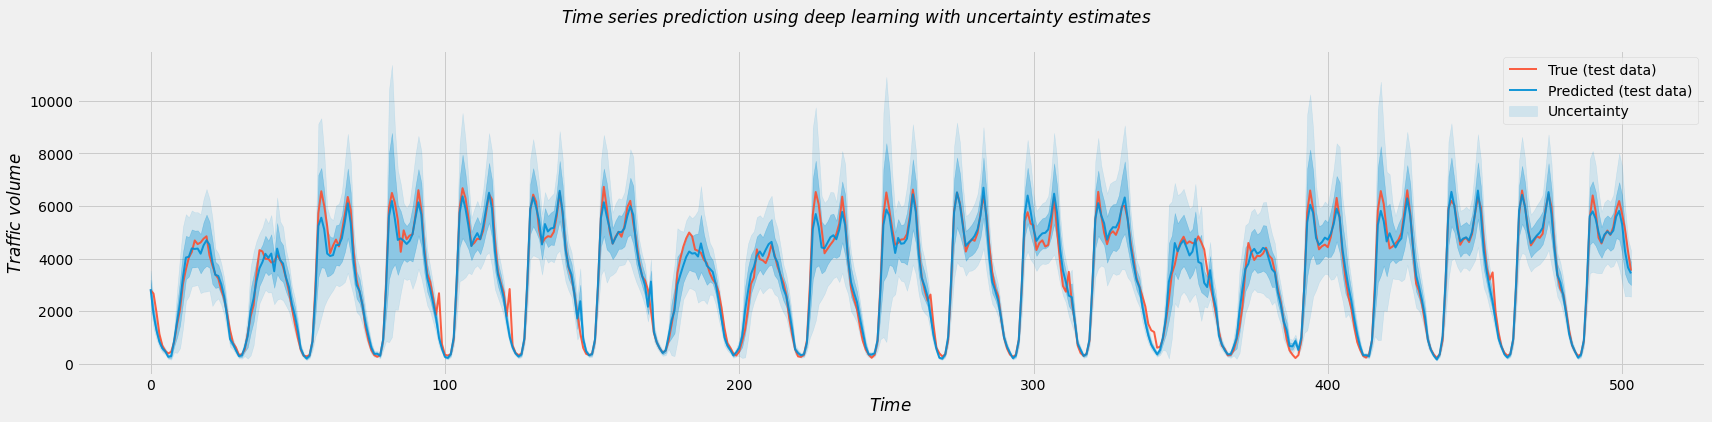

In [8]:
fig,axs = plt.subplots(figsize=(24,6))
start = len(Y) - 24*7*3
end = len(Y)
axs.plot(Y[start:end], '-', lw=2, alpha=0.9, c='C1', label='True (test data)')
axs.plot(Y_hat[start:end], lw=2, alpha=0.9, label='Predicted (test data)')
axs.fill_between(np.arange(end-start), Y_hat_upper[start:end], 
                 Y_hat_lower[start:end], alpha=0.33, color='C0')
axs.fill_between(np.arange(end-start), Y_hat_2upper[start:end], 
                 Y_hat_2lower[start:end], alpha=0.13, color='C0', label='Uncertainty')
axs.legend(loc='best')
axs.set_xlabel('$Time$')
axs.set_ylabel('$Traffic\ volume$')
fig.suptitle('$Time\ series\ prediction\ using\ deep\ learning\ with\ uncertainty\ estimates$')
plt.tight_layout()
plt.savefig('results_large.png', dpi=200)